# Bank Marketing Analysis

by Rong Wan, Hala Arar & Fazeeia Mohammed 2024/11/21

In [4]:

import altair as alt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
#from ucimlrepo import fetch_ucirepo
import altair_ally as aly
import pandera as pa
from pandera import Column, DataFrameSchema
from scipy.stats import pointbiserialr, chi2_contingency
from pandera import Column, DataFrameSchema, Check
from pandera.errors import SchemaErrors

# Summary

This lab report analyzes bank marketing campaigns with the goal of using machine learning to predict whether a customer will subscribe to a term deposit. The dataset, sourced from the UCI Machine Learning Repository, contains demographic and campaign-related information on customers who were contacted via phone for a Portuguese bank's direct marketing campaign (Moro et al., 2014). The target variable is whether or not the customer subscribed to a term deposit. This study evaluates the performance of Logistic Regression and Decision Tree models in predicting customer subscription to term deposits, using metrics such as accuracy, precision, recall, and F1 score. The Logistic Regression model achieved 88.5% accuracy with high precision (0.70) but low recall (0.20), making it suitable for minimizing false positives. Conversely, the Decision Tree model achieved 89.7% accuracy with improved recall (0.23) but lower precision (0.63), better identifying potential subscribers at the cost of higher false positives. Both models emphasize the majority class (non-subscribers) and highlight challenges in detecting true positives. Strategic recommendations include targeted marketing, personalized offers, and continuous monitoring and adjustment of the models to improve performance. By leveraging these models, banks can enhance marketing strategies, optimize resource allocation, and increase conversion rates.

# Introduction

Bank marketing campaigns are a critical tool for financial institutions to promote their products and services, particularly time deposit subscriptions (Meshref, 2020). However, identifying potential customers who are likely to respond positively to these campaigns can be challenging (Meshref, 2020). Despite advances in targeted marketing strategies, response rates for bank marketing campaigns remain low, and ineffective campaigns can lead to wasted resources and decreased customer satisfaction (Xie et al., 2023).

One notable study in this area is "Predictive Analytics and Machine Learning in Direct Marketing for Anticipating Bank Term Deposit Subscriptions" by Zaki et al. (2024). The authors explore how machine learning models, including the SGD Classifier, k-nearest neighbor Classifier, and Random Forest Classifier, can be used to predict bank term deposit subscriptions. The study employs various data exploration and feature engineering techniques to build and evaluate the models, ultimately identifying the Random Forest Classifier as the most effective, achieving an impressive accuracy of 87.5%. This study underscores the potential of machine learning to enhance marketing strategies in the banking sector, providing valuable insights that can help institutions refine their direct marketing approaches and improve customer acquisition.

In recent years, the use of machine learning and data mining techniques in the banking sector has gained significant traction, particularly for customer targeting and marketing optimization. A study by Wang (2020) examines the application of machine learning algorithms, specifically the C5.0 algorithm, to classify bank customers in order to improve marketing strategies. Using the Bank Marketing dataset from the UCI Machine Learning Repository, the study demonstrates how data mining can help identify customer segments, allowing banks to tailor their marketing campaigns more effectively. The classification model results can enhance decision-making processes for banks, ultimately improving marketing efficiency and customer satisfaction. The study highlights the importance of selecting relevant features, handling outliers, and balancing the dataset to ensure more accurate predictions.

This research raises the question of whether a machine learning algorithm can predict whether a customer will subscribe to a term deposit based on customer demographics and campaign-related data. This is an important inquiry because traditional marketing methods often rely on manual segmentation or generalized strategies, which may not capture the nuances of customer behavior. Additionally, by excluding customers who are unlikely to subscribe, banks can reduce campaign costs and improve customer experience. Conversely, accurately identifying potential subscribers allows banks to concentrate efforts on the right audience, improving both efficiency and outcomes. Therefore, if a machine learning algorithm can accurately predict customer subscriptions based on the bank marketing dataset, it could enable more effective, scalable, and data-driven marketing strategies, leading to better resource allocation and enhanced campaign performance.

# Methods 

### Data

The dataset used in this project is the Bank Marketing dataset, sourced from the UCI Machine Learning Repository (Moro et al., 2014). It contains information related to direct marketing campaigns (via phone calls) conducted by a Portuguese banking institution to predict if a client will subscribe to a term deposit. The dataset contains 45,211 rows and 17 columns and it includes features such as age, job type, marital status, education, balance, and details about previous marketing campaigns. The target variable in this study is "y," which indicates whether a customer subscribed to a term deposit (binary: "yes" or "no"). We processed and analyzed this data using Python with libraries such as pandas, scikit-learn, and matplotlib to implement data cleaning, exploratory data analysis, and machine learning models. The data has been pre-processed and contains no missing values.

Unknown counts in each column:
 age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


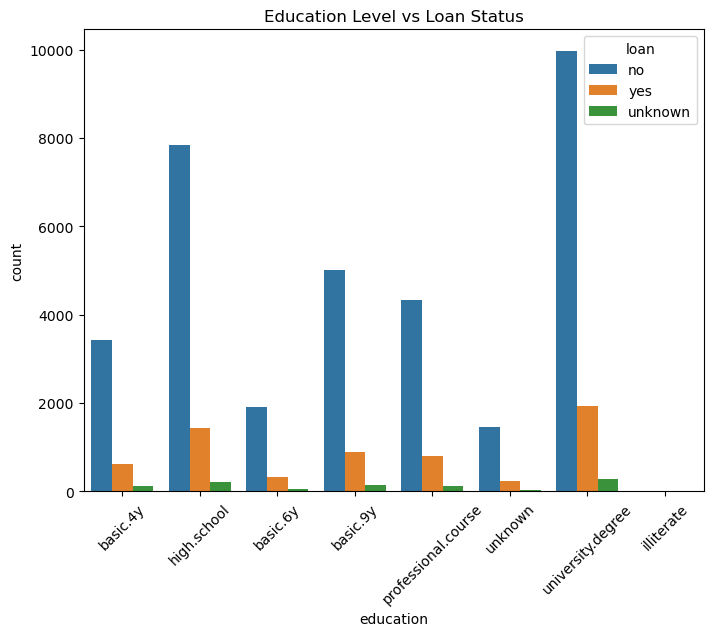

In [6]:
#download and extract data from csv
bank_data = pd.read_csv("../data/bank-additional-full.csv", sep=";")
bank_data

# Check if 'unknown' is still present in any column
unknown_counts = bank_data.isin(['unknown']).sum()
print("Unknown counts in each column:\n", unknown_counts)

# Plot
plt.figure(figsize=(8,6))
sns.countplot(data=bank_data, x='education', hue='loan')
plt.title('Education Level vs Loan Status')
plt.xticks(rotation=45)
plt.show()

In [13]:
import pandas as pd

# Define the data with correct column values, properly wrapped descriptions
data_info = {
    "Variable Name": ["age", "job", "marital", "education", "default", "balance", "housing", "loan", "contact", "day_of_week", "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"],
    "Role": ["Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Target"],
    "Type": ["Integer", "Categorical", "Categorical", "Categorical", "Binary", "Integer", "Binary", "Binary", "Categorical", "Date", "Date", "Integer", "Integer", "Integer", "Integer", "Categorical", "Binary"],
    "Demographic": ["", "Occupation", "Marital Status", "Education Level", "", "", "", "", "", "", "", "", "", "", "", "", ""],
    "Description": [
        "Age", 
        "Type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')", 
        "Marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)", 
        "Education level (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')", 
        "Has credit in default? (binary: 'yes', 'no')", 
        "Average yearly balance (numeric)", 
        "Has housing loan? (binary: 'yes', 'no')", 
        "Has personal loan? (binary: 'yes', 'no')", 
        "Contact communication type (categorical: 'cellular', 'telephone')", 
        "Last contact day of the week (categorical: 'mon', 'tue', 'wed', 'thu', 'fri')", 
        "Last contact month of the year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')", 
        "Last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). It should only be included for benchmark purposes.", 
        "Number of contacts performed during this campaign and for this client (numeric, includes last contact)", 
        "Number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)", 
        "Number of contacts performed before this campaign and for this client", 
        "Outcome of the previous marketing campaign (categorical: 'failure', 'nonexistent', 'success')", 
        "Has the client subscribed to a term deposit? (binary: 'yes', 'no')"
    ],
    "Units": ["years", "", "", "", "", "euros", "", "", "", "", "", "seconds", "", "days", "", ""],
    "Missing Values": ["no", "no", "no", "no", "no", "no", "no", "no", "yes", "no", "no", "no", "no", "yes", "no", "yes", "no"]
}

# Ensure that all lists are the same length
max_length = max(len(v) for v in data_info.values())  # Find the longest column

# Fill shorter columns with empty strings to match the longest column length
for key, value in data_info.items():
    while len(value) < max_length:
        value.append("")  # Append empty string to match the max length

# Create DataFrame
data_info_df = pd.DataFrame(data_info)

# Save as CSV with proper handling of descriptions in quotes
data_info_df.to_csv('data_info.csv', index=False, quoting=1)  # quoting=1 ensures fields with long text are properly quoted

# Display the DataFrame to check
data_info_df


,Variable Name,Role,Type,Demographic,Description,Units,Missing Values
0,age,Feature,Integer,,Age,years,no
1,job,Feature,Categorical,Occupation,"Type of job (categorical: 'admin.', 'blue-coll...",,no
2,marital,Feature,Categorical,Marital Status,"Marital status (categorical: 'divorced', 'marr...",,no
3,education,Feature,Categorical,Education Level,"Education level (categorical: 'basic.4y', 'bas...",,no
4,default,Feature,Binary,,"Has credit in default? (binary: 'yes', 'no')",,no
5,balance,Feature,Integer,,Average yearly balance (numeric),euros,no
6,housing,Feature,Binary,,"Has housing loan? (binary: 'yes', 'no')",,no
7,loan,Feature,Binary,,"Has personal loan? (binary: 'yes', 'no')",,no
8,contact,Feature,Categorical,,Contact communication type (categorical: 'cell...,,yes
9,day_of_week,Feature,Date,,Last contact day of the week (categorical: 'mo...,,no


| Variable Name  | Role   | Type       | Demographic       | Description                                                                                                                                                       | Units    | Missing Values |
|----------------|--------|------------|-------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|----------------|
| age            | Feature| Integer    |                   | Age                                                                                                                                                               | years    | no             |
| job            | Feature| Categorical| Occupation         | Type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown') |          | no             |
| marital        | Feature| Categorical| Marital Status     | Marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)                                             |          | no             |
| education      | Feature| Categorical| Education Level    | Education level (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')            |          | no             |
| default        | Feature| Binary     |                   | Has credit in default? (binary: 'yes', 'no')                                                                                                                     |          | no             |
| balance        | Feature| Integer    |                   | Average yearly balance (numeric)                                                                                                                                 | euros    | no             |
| housing        | Feature| Binary     |                   | Has housing loan? (binary: 'yes', 'no')                                                                                                                          |          | no             |
| loan           | Feature| Binary     |                   | Has personal loan? (binary: 'yes', 'no')                                                                                                                         |          | no             |
| contact        | Feature| Categorical|                   | Contact communication type (categorical: 'cellular', 'telephone')                                                                                                |          | yes            |
| day_of_week    | Feature| Date       |                   | Last contact day of the week (categorical: 'mon', 'tue', 'wed', 'thu', 'fri')                                                                                   |          | no             |
| month          | Feature| Date       |                   | Last contact month of the year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')                                                                              |          | no             |
| duration       | Feature| Integer    |                   | Last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). It should only be included for benchmark purposes. | seconds  | no             |
| campaign       | Feature| Integer    |                   | Number of contacts performed during this campaign and for this client (numeric, includes last contact)                                                            |          | no             |
| pdays          | Feature| Integer    |                   | Number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)                | days     | yes            |
| previous       | Feature| Integer    |                   | Number of contacts performed before this campaign and for this client                                                                                           |          | no             |
| poutcome       | Feature| Categorical|                   | Outcome of the previous marketing campaign (categorical: 'failure', 'nonexistent', 'success')                                                                   |          | yes            |
| y              | Target | Binary     |                   | Has the client subscribed to a term deposit? (binary: 'yes', 'no')                                                                                                |          | no             |


# Data Validation Check

In [ ]:
# Define a function for data validation
data_path = "data/bankmarketing/bank-additional/bank-additional/bank-additional-full.csv"

# Define a function for data validation
def validate_data(df, file_path):
    errors = []

    # 1. Correct data file format
    if not file_path.endswith(".csv"):
        errors.append("Incorrect file format: Expected a .csv file.")

    # 2. Correct column names
    expected_columns = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'] 
    if not set(expected_columns).issubset(df.columns):
        errors.append(f"Incorrect column names. Expected columns: {expected_columns}")

    # 3. No empty observations
    if df.isnull().all(axis=1).any():
        errors.append("Dataset contains rows with all empty values.")

    # 4. Missingness not beyond expected threshold
    threshold = 0.1  # 10% threshold for missing data
    missing_ratios = df.isnull().mean()
    if (missing_ratios > threshold).any():
        high_missing_cols = missing_ratios[missing_ratios > threshold].index.tolist()
        errors.append(f"Columns with missingness beyond {threshold * 100}%: {high_missing_cols}")

    # 5. Correct data types in each column
    expected_dtypes = {
        'age': 'int64',
        'job': 'object',
        'marital': 'object',
        'education': 'object',
        'default': 'object',
        'balance': 'int64',
        'housing': 'object',
        'loan': 'object',
        'contact': 'object',
        'day': 'int64',
        'month': 'object',
        'duration': 'int64',
        'campaign': 'int64',
        'pdays': 'int64',
        'previous': 'int64',
        'poutcome': 'object',
        'y': 'object'
    }
    for col, dtype in expected_dtypes.items():
        if col in df.columns and df[col].dtype.name != dtype:
            errors.append(f"Incorrect data type for column {col}. Expected {dtype}, got {df[col].dtype.name}.")

    # 6. No duplicate observations
    if df.duplicated().any():
        errors.append("Dataset contains duplicate rows.")

    return errors

# Run validation
validation_errors = validate_data(bank_data, data_path)

# Handle validation errors
if validation_errors:
    print("Data validation failed with the following errors:")
    for error in validation_errors:
        print(f"- {error}")
else:
    print("Data validation passed!")

In [ ]:
# No Outliers or Anomalous values: 


outlier_schema = DataFrameSchema(
    {
        "age": Column(pa.Int, pa.Check(lambda x: (x >= 17) & (x <= 100), name="age_check")),
        "duration": Column(pa.Int, pa.Check(lambda x: x >= 0, name="duration_check")),  # Duration should be non-negative
        "campaign": Column(pa.Int, pa.Check(lambda x: x >= 0, name="campaign_check")),  # Campaign count should be >= 0
        "pdays": Column(pa.Int, pa.Check(lambda x: x >= -1, name="pdays_check")),  # -1 indicates no previous contact
        "previous": Column(pa.Int, pa.Check(lambda x: x >= 0, name="previous_check")),  # Previous contacts >= 0
        "emp.var.rate": Column(pa.Float, pa.Check(lambda x: (x >= -3.5) & (x <= 3), name="emp_var_rate_check")),  # Range for employment variation
        "cons.price.idx": Column(pa.Float, pa.Check(lambda x: (x >= 92) & (x <= 95), name="cons_price_idx_check")),  # Reasonable range for consumer price index
        "cons.conf.idx": Column(pa.Float, pa.Check(lambda x: (x >= -51) & (x <= 50), name="cons_conf_idx_check")),  # Consumer confidence range
        "euribor3m": Column(pa.Float, pa.Check(lambda x: (x >= 0) & (x <= 6), name="euribor3m_check")),  # EURIBOR rate should be non-negative and below 6
        "nr.employed": Column(pa.Float, pa.Check(lambda x: (x >= 4900) & (x <= 5500), name="nr_employed_check")),  # Number of employees range
    }
)

# Validate the dataframe for outliers
try:
    outlier_schema.validate(bank_data)
    print("Data passed outlier validation checks.")
except pa.errors.SchemaError as e:
    print("Outlier validation failed:")
    print(e)

In [ ]:
# Correct Category Levels (No String Mismatches or Single Values)
expected_categories = {
    "job": ["admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", 
            "student", "blue-collar", "self-employed", "retired", "technician", "services"],
    "marital": ["married", "divorced", "single", "unknown"],
    "education": ['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course',
 'unknown', 'university.degree', 'illiterate'],
    "default": ["yes", "no", "unknown"],
    "housing": ["yes", "no", "unknown"],
    "loan": ["yes", "no", "unknown"],
    "contact": ["unknown", "telephone", "cellular"],
    "month": ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"],
    "day_of_week": ["mon", "tue", "wed", "thu", "fri"],
    "poutcome": ['nonexistent', 'failure', 'success']
}

# Define the schema for category level checks
category_schema = DataFrameSchema(
    {
        "job": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["job"]), name="job_check")),
        "marital": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["marital"]), name="marital_check")),
        "education": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["education"]), name="education_check")),
        "default": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["default"]), name="default_check")),
        "housing": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["housing"]), name="housing_check")),
        "loan": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["loan"]), name="loan_check")),
        "contact": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["contact"]), name="contact_check")),
        "month": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["month"]), name="month_check")),
        "day_of_week": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["day_of_week"]), name="day_of_week_check")),
        "poutcome": Column(pa.String, pa.Check(lambda x: set(x.unique()).issubset(expected_categories["poutcome"]), name="poutcome_check")),
    }
)

# Validate the dataframe for category level mismatches
try:
    category_schema.validate(bank_data)
    print("Data passed category level validation checks.")
    
    # Check for columns with only a single unique value
    for col in bank_data.select_dtypes(include=['object']).columns:
        unique_values = bank_data[col].nunique()
        if unique_values == 1:
            print(f"Warning: Column '{col}' has only one unique value. It may be non-informative.")

except pa.errors.SchemaError as e:
    print("Category level validation failed:")
    print(e)

In [ ]:
#  Target/Response Variable Follows Expected Distribution 
# Define the schema for validating the target column 'y'
target_schema = pa.DataFrameSchema({
    "y": pa.Column(str, pa.Check.isin(['yes', 'no'], error="Target must be 'yes' or 'no'"), nullable=False)
})

# Validate the DataFrame
try:
    validated_target = target_schema.validate(bank_data)
    print("Target validation passed.")
except pa.errors.SchemaError as e:
    print("Target validation failed:\n", e.failure_cases)


In [ ]:
# Check the distribution of the target variable 'y'
target_column = 'y'

# Calculate the value counts for the target variable
target_counts = bank_data[target_column].value_counts()

# Print out the distribution
print(f"Distribution of '{target_column}':")
print(target_counts)

# Plot the distribution for visual inspection
plt.figure(figsize=(6, 4))
target_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title(f"Distribution of '{target_column}'")
plt.xlabel(target_column)
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



In [ ]:
# No Anomalous Correlations Between Target/Response Variable and Features

def check_correlations_with_target(data):
    # Convert categorical variables to numerical for correlation analysis
    data_encoded = data.copy()
    for column in data_encoded.select_dtypes(include=['object']).columns:
        data_encoded[column] = data_encoded[column].astype('category').cat.codes
    
    correlation_with_target = data_encoded.corr()['y'].drop('y')
    print("Correlations with target variable:\n", correlation_with_target)
    
    # Check for high correlations (greater than 0.9 or less than -0.9)
    anomalous_correlations = correlation_with_target[abs(correlation_with_target) > 0.9]
    if not anomalous_correlations.empty:
        print(f"Warning: Anomalous correlations between target and features: {anomalous_correlations}")
    
try:
    check_correlations_with_target(bank_data)
except Exception as e:
    print("Error in correlation with target check:", e)


In [ ]:
# No Anomalous Correlations Between Features

def check_feature_correlations(data):
    # Convert categorical variables to numerical for correlation analysis
    data_encoded = data.copy()
    for column in data_encoded.select_dtypes(include=['object']).columns:
        data_encoded[column] = data_encoded[column].astype('category').cat.codes
    
    # Calculate correlation matrix
    feature_correlations = data_encoded.corr()
    print("Feature correlation matrix:\n", feature_correlations)
    
    # Find highly correlated features (greater than 0.9 or less than -0.9)
    high_correlation = feature_correlations[abs(feature_correlations) > 0.9]
    high_correlation = high_correlation[(high_correlation != 1).any(axis=1)]  # Remove self-correlations
    
    if not high_correlation.empty:
        print(f"Warning: Anomalous correlations between features:\n{high_correlation}")
    
try:
    check_feature_correlations(bank_data)
except Exception as e:
    print("Error in feature correlation check:", e)


### Analysis

The analysis began with loading and preprocessing the dataset, addressing missing values, encoding categorical features, and scaling numeric variables to ensure consistency across features. The dataset was then split into training and testing sets, with 20% allocated for testing to evaluate model performance. A logistic regression model was chosen for binary classification, implemented through a Pipeline to streamline preprocessing, encoding, and model fitting. To optimize model accuracy, GridSearchCV was used for hyperparameter tuning, and cross-validation was employed to assess the model's robustness. After training the model, its performance was evaluated using various metrics such as accuracy, precision, recall, and F1-score, with confusion matrices and heatmaps created using Seaborn for better visualization. These tools provided insights into the model's ability to differentiate between classes. 

## Results

To evaluate the utility of each predictor in predicting the response variable (y) for the bank marketing dataset, we visualized the distributions of each predictor in the training dataset, coloring them by the class (yes: orange and no: blue). These visualizations include univariate distributions, pairwise correlations, and scatterplots, as seen in the attached figures. In analyzing these plots, we observe significant differences in the distribution centers and spreads of predictors like duration and campaign between the two classes. However, some variables, such as age and balance, show overlapping distributions with less apparent class separation. Furthermore, categorical predictors, such as job and month, exhibit class imbalance but may still hold valuable predictive information. Based on these insights, predictors demonstrating clear separability and meaningful patterns are prioritized for inclusion in the predictive model, while those showing little to no differentiation may be considered for exclusion.

In [ ]:
## visualization

In [ ]:
# Assuming the Bank Marketing dataset is loaded into a DataFrame called `bank_data`
aly.alt.data_transformers.enable('vegafusion')

# Look at the univariate distributions for quantitative variables
aly.dist(bank_data, color='y')


In [ ]:
# Look at the univariate distributions (counts) for categorical variables
# Changing 'target' to an object dtype just for the data passed to the chart
aly.dist(
    bank_data.assign(target=lambda bank_data: bank_data['y'].astype(object)),
    dtype='object',
    color='y'
)

In [ ]:
# Visualize pairwise correlations for quantitative variables
aly.corr(bank_data)

In [ ]:
# Visualize pairwise scatterplots for quantitative variables with high correlations
# Identify columns with at least one high correlation
high_corr_columns = [
    "age",
    "duration",
    "campaign",
    "previous",
    "y",  # Always include the target as well
]

# Sampling the DataFrame to not saturate the charts
aly.pair(bank_data[high_corr_columns].sample(300), color='y')

## Model Creation
### Initially without Hyperparameter optimization using grid search

In [ ]:
# Set a seed for reproducibility
np.random.seed(42)

# Assuming bank_data is already loaded
unknown_columns = bank_data.columns[bank_data.isin(['unknown']).any()]

# Clean the data by replacing 'unknown' values with a placeholder (e.g., 'other')
cleaned_data = bank_data.apply(lambda col: col.replace('unknown', 'other') if col.dtypes == 'object' else col)

# Define feature subsets
numeric_feats = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'campaign']
categorical_feats = ['job', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
drop_feats = ['duration', 'month', 'day_of_week', 'pdays', 'marital', 'previous']

# Separate features and target variable
X = cleaned_data.drop(columns=drop_feats + ['y'])  # Features excluding target 'y' and drop_feats
y = cleaned_data['y']  # Target variable

# Create the column transformer to apply preprocessing
ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # Standard scaling for numeric features
    (OneHotEncoder(drop="if_binary", sparse_output=False), categorical_feats)  # One-hot encoding for categorical features
)

# Create a pipeline with preprocessing and logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('classifier', LogisticRegression(solver='liblinear'))  # Using 'liblinear' solver for small datasets
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Additional evaluation metrics
precision = precision_score(y_test, y_pred, pos_label='yes')  # Specify pos_label
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

# Print additional metrics
print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:
# Set a seed for reproducibility
np.random.seed(42)

# Assuming bank_data is already loaded
unknown_columns = bank_data.columns[bank_data.isin(['unknown']).any()]

# Clean the data by removing rows with 'unknown' values
cleaned_data = bank_data[~bank_data.isin(['unknown']).any(axis=1)]

# Define feature subsets
numeric_feats = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'campaign']
categorical_feats = ['job', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
drop_feats = ['duration', 'month', 'day_of_week', 'pdays', 'marital', 'previous']

# Separate features and target variable
X = cleaned_data.drop(columns=drop_feats + ['y'])  # Features excluding target 'y' and drop_feats
y = cleaned_data['y']  # Target variable

# Create the column transformer to apply preprocessing
ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # Standard scaling for numeric features
    (OneHotEncoder(drop="if_binary", sparse_output=False), categorical_feats)  # One-hot encoding for categorical features
)

# Create a pipeline with preprocessing and logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('classifier', LogisticRegression(solver='liblinear'))  # Using 'liblinear' solver for small datasets
])

# Define the hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],  # Regularization type
    'classifier__solver': ['liblinear'],  # Solver for logistic regression
    'classifier__max_iter': [100, 200, 300]  # Maximum number of iterations for convergence
}

# Create GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best hyperparameters found: ", grid_search.best_params_)

# Make predictions with the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Additional evaluation metrics
# Additional evaluation metrics
precision = precision_score(y_test, y_pred, pos_label='yes')  # Specify pos_label
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')
# Print additional metrics
print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Set a seed for reproducibility
np.random.seed(42)

# Assuming bank_data is already loaded
unknown_columns = bank_data.columns[bank_data.isin(['unknown']).any()]

# Clean the data by replacing 'unknown' values with a placeholder (e.g., 'other')
cleaned_data = bank_data.apply(lambda col: col.replace('unknown', 'other') if col.dtypes == 'object' else col)

# Define feature subsets
numeric_feats = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'campaign']
categorical_feats = ['job', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
drop_feats = ['duration', 'month', 'day_of_week', 'pdays', 'marital', 'previous']

# Separate features and target variable
X = cleaned_data.drop(columns=drop_feats + ['y'])  # Features excluding target 'y' and drop_feats
y = cleaned_data['y']  # Target variable

# Create the column transformer to apply preprocessing
ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # Standard scaling for numeric features
    (OneHotEncoder(drop="if_binary", sparse_output=False), categorical_feats)  # One-hot encoding for categorical features
)

# Create a pipeline with preprocessing and decision tree classifier
pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('classifier', DecisionTreeClassifier(random_state=42))  # Decision tree model
])

# Define parameter grid for grid search
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],  # Maximum depth of tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'classifier__min_samples_leaf': [1, 2, 5],  # Minimum samples required to be a leaf node
    'classifier__criterion': ['gini', 'entropy']  # Criterion for splitting nodes
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Additional evaluation metrics
precision = precision_score(y_test, y_pred, pos_label='yes')  # Specify pos_label
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

# Print additional metrics
print("Decision Tree Evaluation with Optimized Hyperparameters:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Extract feature names after one-hot encoding
ohe = best_model.named_steps['preprocessor'].transformers_[1][1]  # Get the OneHotEncoder
ohe_columns = ohe.get_feature_names_out(categorical_feats)

# Combine numeric and categorical features
feature_names = numeric_feats + list(ohe_columns)



In [ ]:
# Get the decision tree model after optimization
best_tree = best_model.named_steps['classifier']

# Get the feature names after one-hot encoding
ohe = best_model.named_steps['preprocessor'].transformers_[1][1]  # Get the OneHotEncoder
ohe_columns = ohe.get_feature_names_out(categorical_feats)

# Combine the numeric and one-hot encoded feature names
feature_names = numeric_feats + list(ohe_columns)

# Set a higher DPI (dots per inch) for better quality and save the figure
plt.figure(figsize=(20, 15))  # Increase the size for better visibility
plot_tree(best_tree, filled=True, feature_names=feature_names, class_names=['no', 'yes'], rounded=True, max_depth=5)

# Save the plot as a high-resolution image
plt.title('Optimized Decision Tree Visualization (Limited Depth)')
plt.savefig('decision_tree_high_res.png', dpi=300)  # Save with 300 dpi for high resolution
plt.show()

# Discussion

## Logistic Regression Model:

The Logistic Regression model has achieved an accuracy of approximately 88.5%, with the best hyperparameters found as: 
`{'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}`. The confusion matrix for this model is as follows:

- **True Negatives (5236)**: The model correctly identified 5236 non-subscribers, which indicates its strong performance in predicting the majority class (non-subscribers).
- **False Positives (68)**: There are 68 instances where the model incorrectly predicted that non-subscribers would subscribe. This is a relatively low number, indicating that the model is relatively efficient at avoiding unnecessary targeting.
- **False Negatives (632)**: The model missed 632 actual subscribers, which is a significant number and highlights the low recall.
- **True Positives (162)**: The model correctly predicted 162 subscribers, but this number is still quite low, reflecting the model's struggle to identify potential subscribers.

The **Precision** is 0.70, meaning that 70% of the customers predicted as subscribers are actually subscribers. However, the **Recall** is only 0.20, meaning the model captures just 20% of the actual subscribers, which is quite low. This results in an **F1 Score** of 0.32, reflecting a poor balance between precision and recall. Despite the good precision, the low recall suggests that the model is not effectively identifying many actual subscribers, pointing to a significant trade-off between false positives and false negatives. This version of Logistic Regression is more suited to scenarios where **precision** (minimizing false positives) is prioritized over **recall** (capturing all potential subscribers).

## Decision Tree Model:

After performing a grid search for hyperparameter optimization, the best hyperparameters found are: 
`{'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}`. The model achieved an accuracy of approximately 89.7%, with the confusion matrix as follows:

- **True Negatives (7177)**: The Decision Tree correctly predicted 7177 non-subscribers, showing solid performance in predicting the majority class (non-subscribers).
- **False Positives (126)**: There are 126 instances where the model incorrectly predicted non-subscribers as subscribers, which is a moderate number compared to the Logistic Regression model, indicating a higher sensitivity to identifying potential subscribers.
- **False Negatives (720)**: The model failed to predict 720 actual subscribers, a somewhat higher number, reflecting a lower recall than might be ideal.
- **True Positives (215)**: The Decision Tree correctly predicted 215 subscribers, which is an improvement over the Logistic Regression model, suggesting it is better at identifying potential subscribers.

The **Precision** is 0.63, meaning 63% of the customers predicted as subscribers are indeed subscribers. The **Recall** is 0.23, meaning the model captures only 23% of actual subscribers, indicating it still misses a significant portion. This results in an **F1 Score** of 0.34, which is slightly higher than the Logistic Regression model but still reflects an imbalance between precision and recall. The Decision Tree model performs better than Logistic Regression in terms of recall but still struggles to capture a large proportion of the potential subscribers. It might benefit from further adjustments, such as pruning, to reduce the number of false positives and improve its recall.

Although the Decision Tree has a slightly lower accuracy, its **higher recall** (more true positives) suggests it is better at identifying potential subscribers. However, its higher **false positives** indicate that the model might be overfitting, capturing noise in the data. This suggests that the Decision Tree is more sensitive to patterns in the data but might benefit from **regularization** or **pruning** to reduce overfitting.

## Comparison and Implications:


Both models indicate that the most common outcome in the dataset is non-subscription, as reflected in the confusion matrices, where the number of true negatives vastly outweighs the number of true positives. This confirms that "no" is the statistically likely outcome for customer subscription.

- **Logistic Regression Model**: The Logistic Regression model is better suited for situations where minimizing false positives is critical, as its **precision** (0.70) is higher than that of the Decision Tree model. However, its **recall** (0.20) is lower, meaning it misses a significant portion of actual subscribers. This makes the Logistic Regression model more effective in contexts where avoiding unnecessary targeting of non-subscribers is more important than capturing every potential subscriber.

- **Decision Tree Model**: The Decision Tree model, while slightly less accurate overall (**accuracy = 89.7%**), has a better **recall** (0.23), meaning it identifies more true positives compared to Logistic Regression. However, this comes at the cost of an increased number of **false positives** (126). As such, the Decision Tree is better at capturing potential subscribers but may lead to more resources being spent on non-converting customers.

### Implications:
Both models show reasonable accuracy and can be useful for the business’s marketing initiatives to increase term deposits (subscriptions). The Logistic Regression model would be advantageous in scenarios where reducing false positives and minimizing resource expenditure is a priority, while the Decision Tree model could be valuable in situations where capturing more potential subscribers (even at the cost of more false positives). 

Future iterations of these models should focus on improving both **precision** and **recall**, possibly through regularization, pruning, or incorporating more diverse data to better identify customers likely to subscribe. By fine-tuning the models, the business can maximize the effectiveness of its marketing campaigns and increase its return on investment.


## Strategic Recommendations:
Given the insights from the evaluation of both models, here are some actionable strategies to enhance the bank's marketing efforts and improve conversion rates:

### Targeted Marketing:
- Use these models to segment customers into two groups: those with a high likelihood of subscribing (identified by the model as potential positives) and those with a low likelihood (predicted as negatives). Focus marketing efforts on the high-probability segment to optimize resource allocation.

### Campaign Timing:
- Refine marketing strategies by focusing efforts on customers during certain times when they are more likely to respond. The model can be expanded to include temporal features (e.g., day of the week or month) to optimize campaign timing.

### Personalized Offers:
- Tailor offers to individual customers based on characteristics like age, occupation, or previous interactions with the bank (e.g., loan status). The models' predictions can guide personalized messaging, increasing engagement with customers and improving the chances of subscription.

### Improve Conversion Rates:
- Implement **follow-up campaigns** targeting customers predicted as high-likelihood subscribers but who still did not convert. For those predicted as low-likelihood, consider creating new or improved offers to address specific concerns or barriers to subscription.

### Monitor and Adjust:
- Continuously track the performance of both models over time, paying close attention to precision and recall. As more data becomes available, adjust the models and marketing strategies to ensure increasing accuracy and the development of more effective campaigns.

By applying these insights and strategies, the bank can improve its targeting for **long-term deposit** products, increasing conversion rates while making sure the marketing efforts are cost-effective and personalized.

--For the markdown rendering Chat-gpt was used to correct code

# References

Meshref, H. (2020). Predicting loan approval of bank direct marketing data using ensemble machine learning algorithms. International Journal of Circuits, Systems and Signal Processing, 14, 117. https://doi.org/10.46300/9106.2020.14.117

Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306

Wang, D. (2020). Research on bank marketing behavior based on machine learning. AIAM2020: Proceedings of the 2nd International Conference on Artificial Intelligence and Advanced Manufacture, 150–154. https://doi.org/10.1145/3421766.3421800

Xie, C., Zhang, J.-L., Zhu, Y., Xiong, B., & Wang, G.-J. (2023). How to improve the success of bank telemarketing? Prediction and interpretability analysis based on machine learning. Computers & Industrial Engineering, 175, 108874. https://doi.org/10.1016/j.cie.2022.108874

Zaki, A. M., Khodadadi, N., Lim, W. H., & Towfek, S. K. (2024). Predictive analytics and machine learning in direct marketing for anticipating bank term deposit subscriptions. American Journal of Business and Operations Research, 11(1), 79-88. https://doi.org/10.54216/AJBOR.110110